In [2]:
%load_ext autoreload
%autoreload 2

import pytorch_lightning as pl
import os
import numpy as np
import torch
import math
import torch.nn as nn

from torch.utils.data import DataLoader, Subset, RandomSampler, ConcatDataset
from pathlib import Path
from datetime import datetime
import torchvision.models as models

import dl_toolbox.callbacks as callbacks
import dl_toolbox.modules as modules 
import dl_toolbox.datasets as datasets
import dl_toolbox.torch_collate as collate
import dl_toolbox.utils as utils
import dl_toolbox.torch_sample as sample

/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if os.uname().nodename == 'WDTIS890Z': 
    data_root = Path('/mnt/d/pfournie/Documents/data')
    home = Path('/home/pfournie')
    save_root = data_root / 'outputs'
elif os.uname().nodename == 'qdtis056z': 
    data_root = Path('/data')
    home = Path('/d/pfournie')
    save_root = data_root / 'outputs'
else:
    #data_root = Path('/work/OT/ai4geo/DATA/DATASETS')
    data_root = Path(os.environ['TMPDIR'])
    home = Path('/home/eh/fournip')
    save_root = Path('/work/OT/ai4usr/fournip') / 'outputs'

In [4]:
# datasets params
dataset_name = 'NWPU-RESISC45'
data_path = data_root / dataset_name
nomenclature = datasets.ResiscNomenclatures['all'].value
num_classes=len(nomenclature)

train = (0,50)
train_idx = [700*i+j for i in range(num_classes) for j in range(*train)]
train_aug = 'd4_color-3'

val = (600, 700)
val_idx = [700*i+j for i in range(num_classes) for j in range(*val)]
val_aug = 'no'

unsup_train = (50, 100)
unsup_idx = [700*i+j for i in range(num_classes) for j in range(*unsup_train)]
unsup_aug = 'd4'

# dataloaders params
batch_size = 16
num_workers=6

# network params
out_channels=num_classes
weights = 'IMAGENET1K_V1'

# module params
mixup=0. # incompatible with ignore_zero=True
class_weights = [1.] * num_classes
initial_lr=0.001
ttas=[]
alpha_ramp=utils.SigmoidRamp(2,4,0.,5.)
pseudo_threshold=0.9
consist_aug='color-5'
ema_ramp=utils.SigmoidRamp(2,4,0.9,0.99)

# trainer params
num_epochs = 5
accelerator='gpu'
devices=1
multiple_trainloader_mode='min_size'
limit_train_batches=1.
limit_val_batches=1.
save_dir = save_root / dataset_name
log_name = 'labels:all_nbtran:600'
ckpt_path=None # '/data/outputs/test_bce_resisc/version_2/checkpoints/epoch=49-step=14049.ckpt'

In [5]:
log_name = f'train={train}_unsup_train={unsup_train}'

train_set = Subset(
    datasets.Resisc(
        data_path=data_path,
        img_aug=train_aug,
        nomenclature=nomenclature
    ),
    indices=train_idx
)

val_set = Subset(
    datasets.Resisc(
        data_path=data_path,
        img_aug=val_aug,
        nomenclature=nomenclature
    ),
    indices=val_idx
)   

epoch_steps = int(np.ceil(len(train_set) / batch_size))
num_train_samples = epoch_steps * batch_size
#max_steps=num_epochs * epoch_steps

train_dataloaders = {}

train_dataloaders['sup'] = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate.CustomCollate(),
    sampler=RandomSampler(
        data_source=train_set,
        replacement=True,
        num_samples=num_train_samples
    ),
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True
)

val_dataloader = DataLoader(
    dataset=val_set,
    shuffle=False,
    collate_fn=collate.CustomCollate(),
    batch_size=batch_size,
    num_workers=num_workers,
)

classes found :  {'airplane': 0, 'bridge': 1, 'commercial_area': 2, 'golf_course': 3, 'island': 4, 'mountain': 5, 'railway_station': 6, 'sea_ice': 7, 'storage_tank': 8, 'airport': 9, 'chaparral': 10, 'dense_residential': 11, 'ground_track_field': 12, 'lake': 13, 'overpass': 14, 'rectangular_farmland': 15, 'ship': 16, 'tennis_court': 17, 'baseball_diamond': 18, 'church': 19, 'desert': 20, 'harbor': 21, 'meadow': 22, 'palace': 23, 'river': 24, 'snowberg': 25, 'terrace': 26, 'basketball_court': 27, 'circular_farmland': 28, 'forest': 29, 'industrial_area': 30, 'medium_residential': 31, 'parking_lot': 32, 'roundabout': 33, 'sparse_residential': 34, 'thermal_power_station': 35, 'beach': 36, 'cloud': 37, 'freeway': 38, 'intersection': 39, 'mobile_home_park': 40, 'railway': 41, 'runway': 42, 'stadium': 43, 'wetland': 44}
num samples in dataset :  31500
classes found :  {'airplane': 0, 'bridge': 1, 'commercial_area': 2, 'golf_course': 3, 'island': 4, 'mountain': 5, 'railway_station': 6, 'sea_ic

In [6]:
network = models.efficientnet_b0(
    num_classes=out_channels if weights is None else 1000,
    weights=weights
)
if weights is not None:
    # switching head for num_class and init
    head = nn.Linear(1280, out_channels) # 1280 comes from 4 * lastconv_input_channels=320 in efficientnet_b0
    network.classifier[-1] = head
    init_range = 1.0 / math.sqrt(out_channels)
    nn.init.uniform_(head.weight, -init_range, init_range)
    nn.init.zeros_(head.bias)

### Building lightning module
module = modules.Supervised(
    mixup=mixup, # incompatible with ignore_zero=True
    network=network,
    #network2=network2,
    num_classes=num_classes,
    class_weights=class_weights,
    initial_lr=initial_lr,
    ttas=ttas,
    #alpha_ramp=alpha_ramp,
    #pseudo_threshold=pseudo_threshold,
    #consist_aug=consist_aug,
    #ema_ramp=ema_ramp
)

/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['network'])`.
  rank_zero_warn(


In [7]:
### Metrics and plots from confmat callback
metrics_from_confmat = callbacks.MetricsFromConfmat(        
    num_classes=num_classes,
    class_names=[label.name for label in nomenclature]
)

### Trainer instance
logger = pl.loggers.TensorBoardLogger(
    save_dir=save_dir,
    name=log_name,
    version=f'{datetime.now():%d%b%y-%Hh%Mm%S}'
)

trainer = pl.Trainer(
    max_epochs=num_epochs,
    accelerator=accelerator,
    devices=devices,
    multiple_trainloader_mode=multiple_trainloader_mode,
    num_sanity_val_steps=0,
    limit_train_batches=limit_train_batches,
    limit_val_batches=limit_val_batches,
    logger=logger,
    callbacks=[
        pl.callbacks.ModelCheckpoint(),
        pl.callbacks.EarlyStopping(
            monitor='Val_loss',
            patience=10
        ),
        metrics_from_confmat,
        callbacks.MyProgressBar()
    ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


In [8]:
trainer.fit(
    model=module,
    train_dataloaders=train_dataloaders,
    val_dataloaders=val_dataloader,
    ckpt_path=ckpt_path
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | network | EfficientNet     | 4.1 M 
1 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.261    Total estimated model params size (MB)
/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Epoch 0:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 151/173 [00:09<00:01, 15.30it/s, loss=1.11, v_num=0m42]

/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:10<00:00, 16.78it/s, loss=1.11, v_num=0m42]

/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:12<00:00, 13.92it/s, loss=0.538, v_num=0m42]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:12<00:00, 13.60it/s, loss=0.538, v_num=0m42]


In [45]:
pred_set = Subset(
    datasets.Resisc(
        data_path=data_path,
        img_aug='no',
        nomenclature=nomenclature
    ),
    indices=unsup_idx
)

pred_dataloader = DataLoader(
    dataset=pred_set,
    shuffle=False,
    collate_fn=collate.CustomCollate(),
    batch_size=batch_size,
    num_workers=num_workers
)

classes found :  {'airplane': 0, 'bridge': 1, 'commercial_area': 2, 'golf_course': 3, 'island': 4, 'mountain': 5, 'railway_station': 6, 'sea_ice': 7, 'storage_tank': 8, 'airport': 9, 'chaparral': 10, 'dense_residential': 11, 'ground_track_field': 12, 'lake': 13, 'overpass': 14, 'rectangular_farmland': 15, 'ship': 16, 'tennis_court': 17, 'baseball_diamond': 18, 'church': 19, 'desert': 20, 'harbor': 21, 'meadow': 22, 'palace': 23, 'river': 24, 'snowberg': 25, 'terrace': 26, 'basketball_court': 27, 'circular_farmland': 28, 'forest': 29, 'industrial_area': 30, 'medium_residential': 31, 'parking_lot': 32, 'roundabout': 33, 'sparse_residential': 34, 'thermal_power_station': 35, 'beach': 36, 'cloud': 37, 'freeway': 38, 'intersection': 39, 'mobile_home_park': 40, 'railway': 41, 'runway': 42, 'stadium': 43, 'wetland': 44}
num samples in dataset :  31500


In [53]:
pl_dir = os.path.join(
    save_dir,
    log_name,
    logger.log_dir,
    dataset_name
)

pseudolabel_writer = callbacks.ClassifPredsWriter(
    out_path=pl_dir,
    write_interval='batch',
    cls_names=[label.name for label in nomenclature],
    threshold=0.9
)

pred_trainer = pl.Trainer(
    accelerator=accelerator,
    devices=devices,
    logger=None,
    callbacks=[
        pseudolabel_writer,
        #callbacks.MyProgressBar(),
    ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [54]:
pred_trainer.predict(
    model=module,
    dataloaders=pred_dataloader,
    return_predictions=False
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:02<00:00, 48.27it/s]


In [39]:
pl_set = datasets.Resisc(
    data_path=pl_dir,
    img_aug='no',
    nomenclature=nomenclature
)

pl_train_set = ConcatDataset([train_set, pl_set])

pl_sampler = sample.BalancedConcat(
    lengths=[len(train_set), len(pl_set)],
    num_samples=len(pl_train_set)
)

pl_train_dataloaders = {}

pl_train_dataloaders['sup'] = DataLoader(
    dataset=pl_train_set,
    #sampler=pl_sampler,
    shuffle=True,
    collate_fn=collate.CustomCollate(),
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True
)

#val_set = Subset(
#    datasets.Resisc(
#        data_path=data_path,
#        img_aug=val_aug,
#        nomenclature=nomenclature
#    ),
#    indices=val_idx
#)  
#
#pl_val_dataloader = DataLoader(
#    dataset=val_set,
#    shuffle=False,
#    collate_fn=collate.CustomCollate(),
#    batch_size=batch_size,
#    num_workers=num_workers
#)
#
#print(len(pl_train_set))
#print(num_val_samples)

classes found :  {'bridge': 1, 'commercial_area': 2, 'golf_course': 3, 'island': 4, 'mountain': 5, 'railway_station': 6, 'sea_ice': 7, 'storage_tank': 8, 'airport': 9, 'chaparral': 10, 'dense_residential': 11, 'ground_track_field': 12, 'lake': 13, 'overpass': 14, 'ship': 16, 'tennis_court': 17, 'baseball_diamond': 18, 'desert': 20, 'harbor': 21, 'meadow': 22, 'palace': 23, 'river': 24, 'snowberg': 25, 'terrace': 26, 'circular_farmland': 28, 'forest': 29, 'medium_residential': 31, 'parking_lot': 32, 'roundabout': 33, 'sparse_residential': 34, 'thermal_power_station': 35, 'beach': 36, 'freeway': 38, 'intersection': 39, 'railway': 41, 'runway': 42, 'wetland': 44}
num samples in dataset :  179


dict_keys(['image', 'label', 'crop', 'crop_tf', 'path', 'crs'])


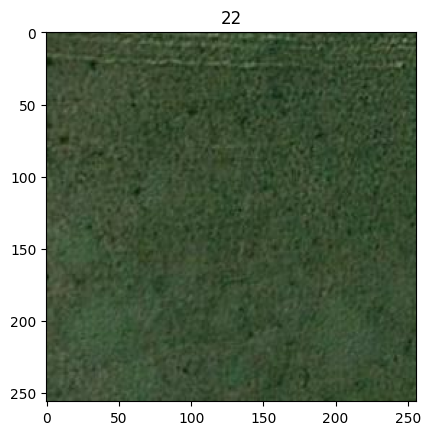

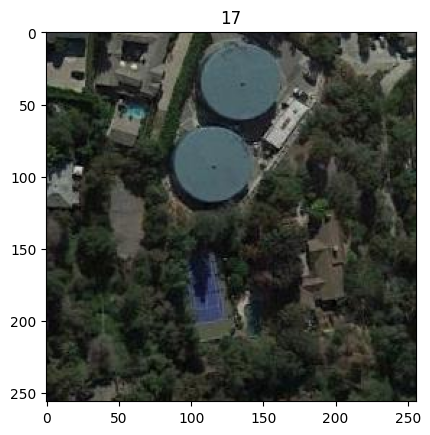

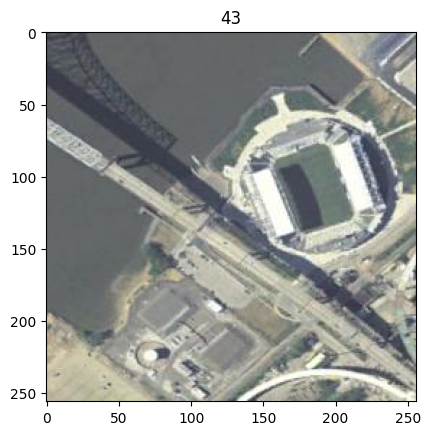

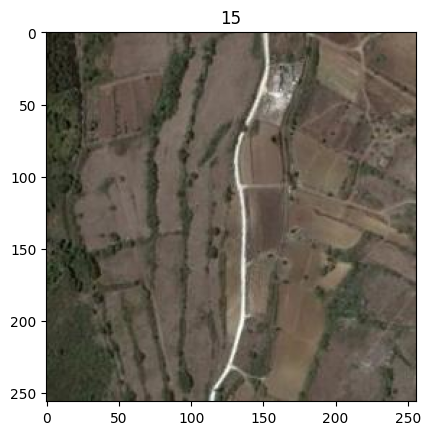

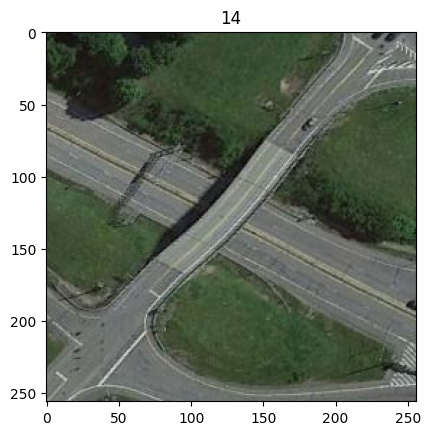

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

item = val_set[2280]
fig, ax = plt.subplots(1, 1)
ax.imshow(item['image'].numpy().transpose(1,2,0)[...,:3])
ax.set_title(int(item['label']))
ax.autoscale_view()

#for i, batch in enumerate(val_dataloader):
#    print(batch.keys())
#    for j in range(4):
#        f, ax = plt.subplots(ncols=1)
#        ax.imshow(batch['image'][j].numpy().transpose(1,2,0)[...,:3])
#        ax.set_title(int(batch['label'][j]))
#
#    break

In [41]:
pl_network = models.efficientnet_b0(
    num_classes=out_channels if weights is None else 1000,
    weights=weights
)
if weights is not None:
    # switching head for num_class and init
    head = nn.Linear(1280, out_channels) # 1280 comes from 4 * lastconv_input_channels=320 in efficientnet_b0
    pl_network.classifier[-1] = head
    init_range = 1.0 / math.sqrt(out_channels)
    nn.init.uniform_(head.weight, -init_range, init_range)
    nn.init.zeros_(head.bias)

pl_module = modules.Supervised(
    mixup=mixup, # incompatible with ignore_zero=True
    network=pl_network,
    num_classes=num_classes,
    class_weights=class_weights,
    initial_lr=initial_lr,
    ttas=ttas
)


In [42]:
### Trainer instance
pl_trainer = pl.Trainer(
    max_epochs=num_epochs,
    accelerator=accelerator,
    devices=devices,
    multiple_trainloader_mode=multiple_trainloader_mode,
    num_sanity_val_steps=0,
    limit_train_batches=limit_train_batches,
    limit_val_batches=limit_val_batches,
    logger=logger,
    callbacks=[
        pl.callbacks.ModelCheckpoint(),
        pl.callbacks.EarlyStopping(
            monitor='Val_loss',
            patience=10
        ),
        metrics_from_confmat,
        callbacks.MyProgressBar()
    ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


In [43]:
pl_trainer.fit(
    model=pl_module,
    train_dataloaders=pl_train_dataloaders,
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | network | EfficientNet     | 4.1 M 
1 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.261    Total estimated model params size (MB)


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:14<00:00, 12.96it/s, loss=0.66, v_num=0m42]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:14<00:00, 12.72it/s, loss=0.66, v_num=0m42]


In [44]:
!jupyter nbconvert --to script train_resisc_pl.ipynb

[NbConvertApp] Converting notebook train_resisc_pl.ipynb to script
[NbConvertApp] Writing 9522 bytes to train_resisc_pl.py
